Для решения второй задачи мы сосредоточились на отборе признаков, что позволило нам выделить наиболее информативные характеристики для анализа.

<p>Мы построили матрицу связности исключительно на основе выбранных признаков X. Далее мы применили кросс-валидацию для подбора оптимальных параметров модели логистической регрессии.</p>

<p>В этом процессе мы использовали метод главных компонент (PCA) для снижения размерности данных. Также мы применили стандартное масштабирование (StandardScaler) и нормализацию по Z-score, что обеспечило равномерное распределение данных.</p>

File version: 1.1

In [1]:
import sys;

print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['../'])

Python 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)] on win32


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scripts.data_utils import get_connectome
from scripts.classification_models import LogRegPCA
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier

In [3]:
hcp_table = pd.read_excel('../data/atlas/HCPex_Atlas_Description.xlsx',
                          index_col='HCPex_ID').sort_index()
hcp_table.head()

,NEW_ID,Label,Short_label,Cortical Division,Cortical_Division_Number,X,Y,Z,ColeAnticevic_functional_network,ColeAnticevic_functional_network_label
HCPex_ID,,,,,,,,,,
1,1,Primary_Visual_Cortex_L,L_V1,Primary_Visual,1,-10.078,-84.159,1.759,1,Visual1
2,3,Second_Visual_Area_L,L_V2,Early_Visual,2,-12.044,-82.059,4.029,2,Visual2
3,5,Third_Visual_Area_L,L_V3,Early_Visual,2,-16.607,-84.793,7.259,2,Visual2
4,7,Fourth_Visual_Area_L,L_V4,Early_Visual,2,-29.556,-86.009,-1.542,2,Visual2
5,9,IntraParietal_Sulcus_Area_1_L,L_IPS1,Dorsal_Stream_Visual,3,-24.456,-74.776,38.047,2,Visual2


In [4]:
hcp_table[hcp_table['ColeAnticevic_functional_network_label'].isin(['Visual1','Visual2'])]

,NEW_ID,Label,Short_label,Cortical Division,Cortical_Division_Number,X,Y,Z,ColeAnticevic_functional_network,ColeAnticevic_functional_network_label
HCPex_ID,,,,,,,,,,
1,1,Primary_Visual_Cortex_L,L_V1,Primary_Visual,1,-10.078,-84.159,1.759,1,Visual1
2,3,Second_Visual_Area_L,L_V2,Early_Visual,2,-12.044,-82.059,4.029,2,Visual2
3,5,Third_Visual_Area_L,L_V3,Early_Visual,2,-16.607,-84.793,7.259,2,Visual2
4,7,Fourth_Visual_Area_L,L_V4,Early_Visual,2,-29.556,-86.009,-1.542,2,Visual2
5,9,IntraParietal_Sulcus_Area_1_L,L_IPS1,Dorsal_Stream_Visual,3,-24.456,-74.776,38.047,2,Visual2
6,11,Area_V3A_L,L_V3A,Dorsal_Stream_Visual,3,-15.327,-90.377,27.933,2,Visual2
7,13,Area_V3B_L,L_V3B,Dorsal_Stream_Visual,3,-27.171,-81.718,17.571,2,Visual2
8,15,Sixth_Visual_Area_L,L_V6,Dorsal_Stream_Visual,3,-15.102,-79.083,30.836,2,Visual2
9,17,Area_V6A_L,L_V6A,Dorsal_Stream_Visual,3,-21.277,-85.896,42.021,2,Visual2


In [5]:
# load open data from Beijing Normal University
X = np.load('../data/ts_cut/HCPex/bnu1.npy')
print(X.shape)

(71, 240, 419)


In [6]:
visual_fields = hcp_table[hcp_table['ColeAnticevic_functional_network_label'].str.contains('Visual')].index.values
print("Индексы зрительных областей:", visual_fields)

# эти индексы мы использовали в дальнейшем в scripts/data_utils/

Индексы зрительных областей: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26 108 110 127 131 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 288 290 307 311]


In [7]:
# Если нужно сохранить отфильтрованный атлас для дальнейшего использования
visual_regions = hcp_table.loc[visual_fields]

In [8]:
visual_indicies = visual_regions.NEW_ID.tolist()

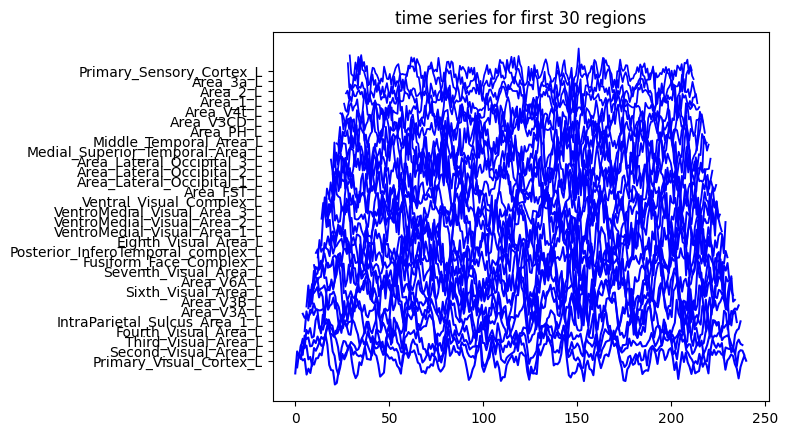

In [9]:
num_components_to_display = 30
tsd = X[0, :, :num_components_to_display]
for i in range(num_components_to_display):
    xscale = 1 - i / len(tsd) * 2
    lw = 1.5 - i / len(tsd) * 2
    plt.plot((xscale * np.linspace(-0.5, 0.5, len(tsd)) + 0.5) * len(tsd), i + tsd[:, i], color="b", lw=lw)
plt.gca().set_yticks(ticks=np.arange(num_components_to_display),
                     labels=hcp_table['Label'][:num_components_to_display].values)
plt.title(f'time series for first {num_components_to_display} regions')
plt.show()

## Код

In [10]:
bnu_series_path = '../data/ts_cut/HCPex/bnu{}.npy'
bnu_labels_path = '../data/ts_cut/HCPex/bnu.csv'
ihb_series_path = '../data/ts_cut/HCPex/ihb.npy'
ihb_labels_path = '../data/ts_cut/HCPex/ihb.csv'

X_bnu = np.concatenate([np.load(bnu_series_path.format(i)) for i in (1, 2)], axis=0)
print(X_bnu.shape)
Y_bnu = pd.read_csv(bnu_labels_path)
print(Y_bnu.shape)
X_ihb = np.load(ihb_series_path)
print(X_ihb.shape)
Y_ihb = pd.read_csv(ihb_labels_path)
print(Y_ihb.shape)

(142, 240, 419)
(142, 1)
(20, 120, 419)
(20, 1)


<Axes: >

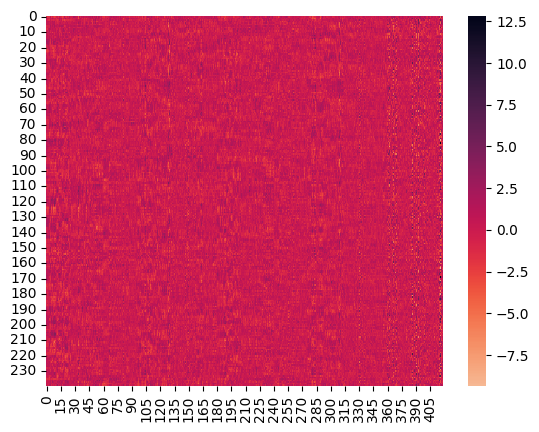

In [11]:
sns.heatmap(X_bnu[0], center = 0, cmap = 'rocket_r')

In [12]:
X_bnu = get_connectome(timeseries=X_bnu)
X_ihb = get_connectome(timeseries=X_ihb)

In [13]:
# concat the train data
X = np.concatenate([X_bnu, X_ihb])
Y = np.concatenate([Y_bnu, Y_ihb])

In [14]:
x_train, x_validate, y_train, y_validate = train_test_split(X, Y,
                                                            test_size=0.29, random_state=42)
print(x_train.shape, x_validate.shape)
print(y_train.shape, y_validate.shape)

(115, 60, 60) (47, 60, 60)
(115, 1) (47, 1)


Text(0.5, 1.0, '[0.]')

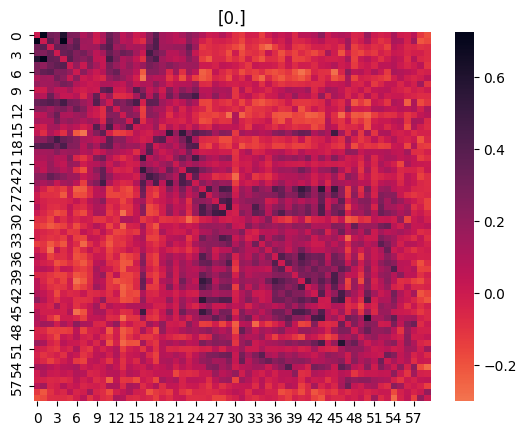

In [15]:
i = 3
sns.heatmap(x_train[i], center = 0, cmap = 'rocket_r')
plt.title(y_train[i])

---

In [16]:
logreg = LogRegPCA(penalty='l2', C=0.1, solver='liblinear', max_iter=1000)
train_acc = logreg.model_training(x_train, y_train)
conf_mat, acc, f1 = logreg.model_testing(x_validate, y_validate)

Accuracy on train: 1.0
Accuracy on test: 0.936
F1 score on test: 0.937


In [17]:
import pickle

# save model and weights 

pkl_filename = "./model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(logreg, file)

In [18]:
# create local environment same as Yandex Contest
import os
import shutil

if not os.path.exists('./data/ts_cut/HCPex/'):
    os.makedirs('./data/ts_cut/HCPex/')

np.save('./data/ts_cut/HCPex/predict.npy', np.concatenate([np.load(bnu_series_path.format(i)) for i in (1, 2)], axis=0))


In [20]:
# create script, which loads model, does all preprocessing and outputs solution.csv

import numpy as np
import pandas as pd
import pickle

from scripts.data_utils import get_connectome
from scripts.classification_models import LogRegPCA

X = np.load('./data/ts_cut/HCPex/predict.npy')

print(X.shape)
X = get_connectome(X)
print('Connectome_shape = ',X.shape)

with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

y_pred = model.model_predict(X)
print(y_pred)

solution = pd.DataFrame(data=y_pred, columns=['prediction'])
solution.to_csv('./solution.csv', index=False)

(142, 240, 419)
Connectome_shape =  (142, 60, 60)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.]


In [21]:
# build the .zip to submit
import zipfile
import datetime

# save source from previous cell into file
# will produce the correct result only in case of running previous cell just before
with open('run.py', 'w') as f_run:
    f_run.write(_ih[-2])

with open('run.sh', 'w') as f_run_sh:
    f_run_sh.write('export PATH=/usr/conda/bin:$PATH\npython run.py')

with open('train.py', 'w') as f_run:
    f_run.write('print("\\n".join(map(str, range(100))))')

with open('train.sh', 'w') as f_run_sh:
    f_run_sh.write('export PATH=/usr/conda/bin:$PATH\npython train.py')

with open('Makefile', 'w') as f_makefile:
    f_makefile.write('''all: build

build:
	@echo 'starting....'
	bash train.sh
run:
	bash run.sh
train:
	bash train.sh
''')

submission_zip = zipfile.ZipFile(f"submission-{datetime.datetime.now()}.zip".replace(':', '-').replace(' ', '-'), "w")
submission_zip.write('./Makefile', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('run.py', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('run.sh', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('train.py', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('train.sh', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('model.pkl', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('scripts', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('scripts/__init__.py', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('scripts/classification_models.py', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('scripts/data_utils.py', compress_type=zipfile.ZIP_DEFLATED)

submission_zip.close()